In [1]:
import torch
from torch import nn
from torch import optim
from torch.utils.data import DataLoader
import torchvision

from torchvision import datasets
from torchvision import transforms
from torchvision.utils import make_grid

from tqdm import tqdm
#from torchinfo import summary

import numpy as np
import matplotlib.pyplot as plt


In [2]:
print('GPU name:', torch.cuda.get_device_name(), '\n')
device = 'cuda' if torch.cuda.is_available() else 'cpu'

GPU name: NVIDIA A100-PCIE-40GB 



# Load MNIST dataset


In [3]:
transform = transforms.Compose([
    transforms.Resize((32, 32)),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=(0.5,), std=(0.5,))])

training_dataset = datasets.MNIST(root='./data_src', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data_src', train=False, download=True, transform=transform)

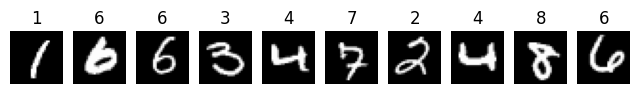

In [4]:
# show 10 randomly selected samples from the training dataset

fig, axis = plt.subplots(nrows=1, ncols=10, figsize=(8, 1))

for ax, _ in zip(axis.ravel(), range(10)):
    inx = np.random.randint(len(training_dataset))
    ax.imshow(training_dataset.data[inx], cmap='gray')
    ax.set_title(int(training_dataset.targets[inx]), fontsize=12)
    ax.axis(False)

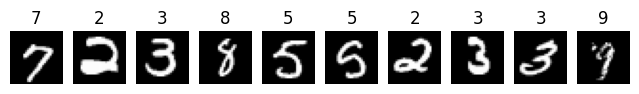

In [5]:
# show 10 randomly selected samples from the test dataset

fig, axis = plt.subplots(nrows=1, ncols=10, figsize=(8, 1))

for ax, _ in zip(axis.ravel(), range(10)):
    inx = np.random.randint(len(test_dataset))
    ax.imshow(test_dataset.data[inx], cmap='gray')
    ax.set_title(int(test_dataset.targets[inx]), fontsize=12)
    ax.axis(False)

# Define dataloaders


In [6]:

training_dataloader = DataLoader(training_dataset, batch_size=200, shuffle=True, drop_last=True, num_workers=4, pin_memory=True)
test_dataloader = DataLoader(test_dataset, batch_size=200, shuffle=False, drop_last=True, num_workers=4, pin_memory=True)   

# Define Linear_Variance_Scheduler


In [7]:
class Linear_Variance_Scheduler:
    def __init__(self, time_steps, beta_start, beta_end, device='cuda'):
        
        self.time_steps = time_steps
        self.beta_start = beta_start
        self.beta_end = beta_end
        self.device = device
        
        self.betas = torch.linspace(self.beta_start, self.beta_end, self.time_steps, device=self.device)
        self.alphas = 1 - self.betas
        self.alpha_bar = torch.cumprod(self.alphas, dim=0)
        self.sqrt_alpha_bar = torch.sqrt(self.alpha_bar)
        self.sqrt_one_minus_alpha_bar = torch.sqrt(1 - self.alpha_bar)
        
    def diffusion_process(self, x, noise, t):
        t = torch.clamp(t, max=self.time_steps - 1)  # Ensure t is within bounds
        sqrt_alpha_bar = self.sqrt_alpha_bar[t].view(-1, 1, 1, 1)
        sqrt_one_minus_alpha_bar = self.sqrt_one_minus_alpha_bar[t].view(-1, 1, 1, 1)
        return sqrt_alpha_bar * x + sqrt_one_minus_alpha_bar * noise
    
    # Reverse process
    def ddpm_sampling(self, model, num_samples, channels, img_size):
        model.eval()
        with torch.inference_mode():
            x = torch.randn((num_samples, channels, img_size, img_size)).to(self.device)
            collect = []
            for i in tqdm(reversed(range(self.time_steps))):
                t = (torch.ones(num_samples) * i).long().to(self.device)
                pred_noise = model(x, t)
                alphas = self.alphas[t][:, None, None, None]
                alpha_bar = self.alpha_bar[t][:, None, None, None]
                betas = self.betas[t][:, None, None, None]
                if i > 1:
                    noise = torch.randn_like(x)
                else:
                    noise = torch.zeros_like(x)
                x = 1 / torch.sqrt(alphas) * (x - ((1 - alphas) / (torch.sqrt(1 - alpha_bar))) * pred_noise) +\
                    torch.sqrt(betas) * noise
                if (i+1) % 100 == 0 or i==0:
                    collect.append(x)
        return x, collect

# Forward process output


In [8]:
t_step = torch.linspace(start=0, end=1000-1, steps=11).long()
get_img = training_dataset[0][0]

get_img_stack = torch.stack([get_img]*11)
get_noise_stack = torch.randn_like(get_img_stack)

In [9]:
noisy_img_stack = Linear_Variance_Scheduler(time_steps=1000, beta_start=0.0001, beta_end=0.02,
                                            device='cpu').diffusion_process(get_img_stack, get_noise_stack, t_step)

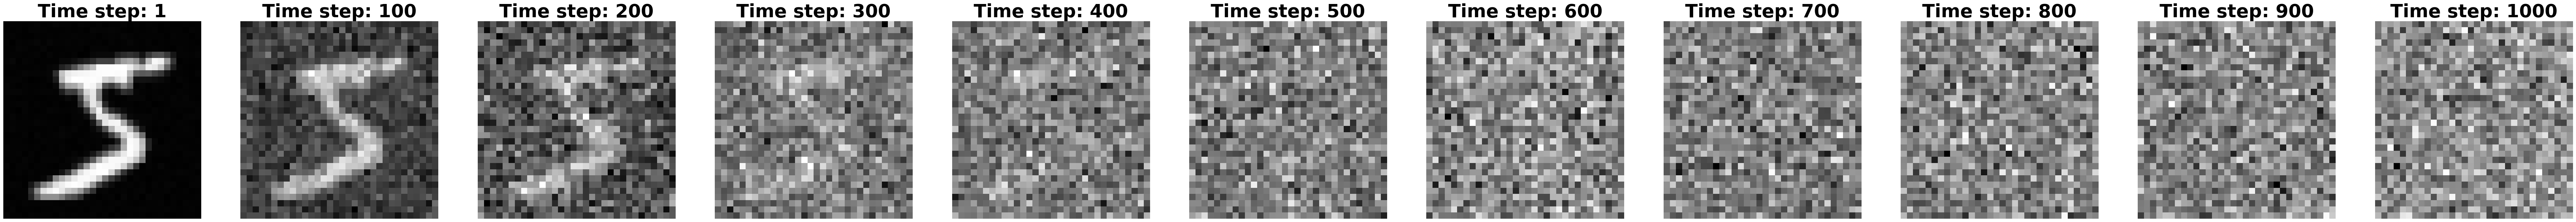

In [10]:
fig, ax = plt.subplots(nrows=1, ncols=11, figsize=(100, 100))

for idx, img in enumerate(noisy_img_stack):
    ax[idx].imshow(img.squeeze(), cmap='gray')
    ax[idx].set_title(f'Time step: {t_step[idx]+1}', fontsize=40, fontweight='bold')
    ax[idx].axis(False)

### Play with forward parameters

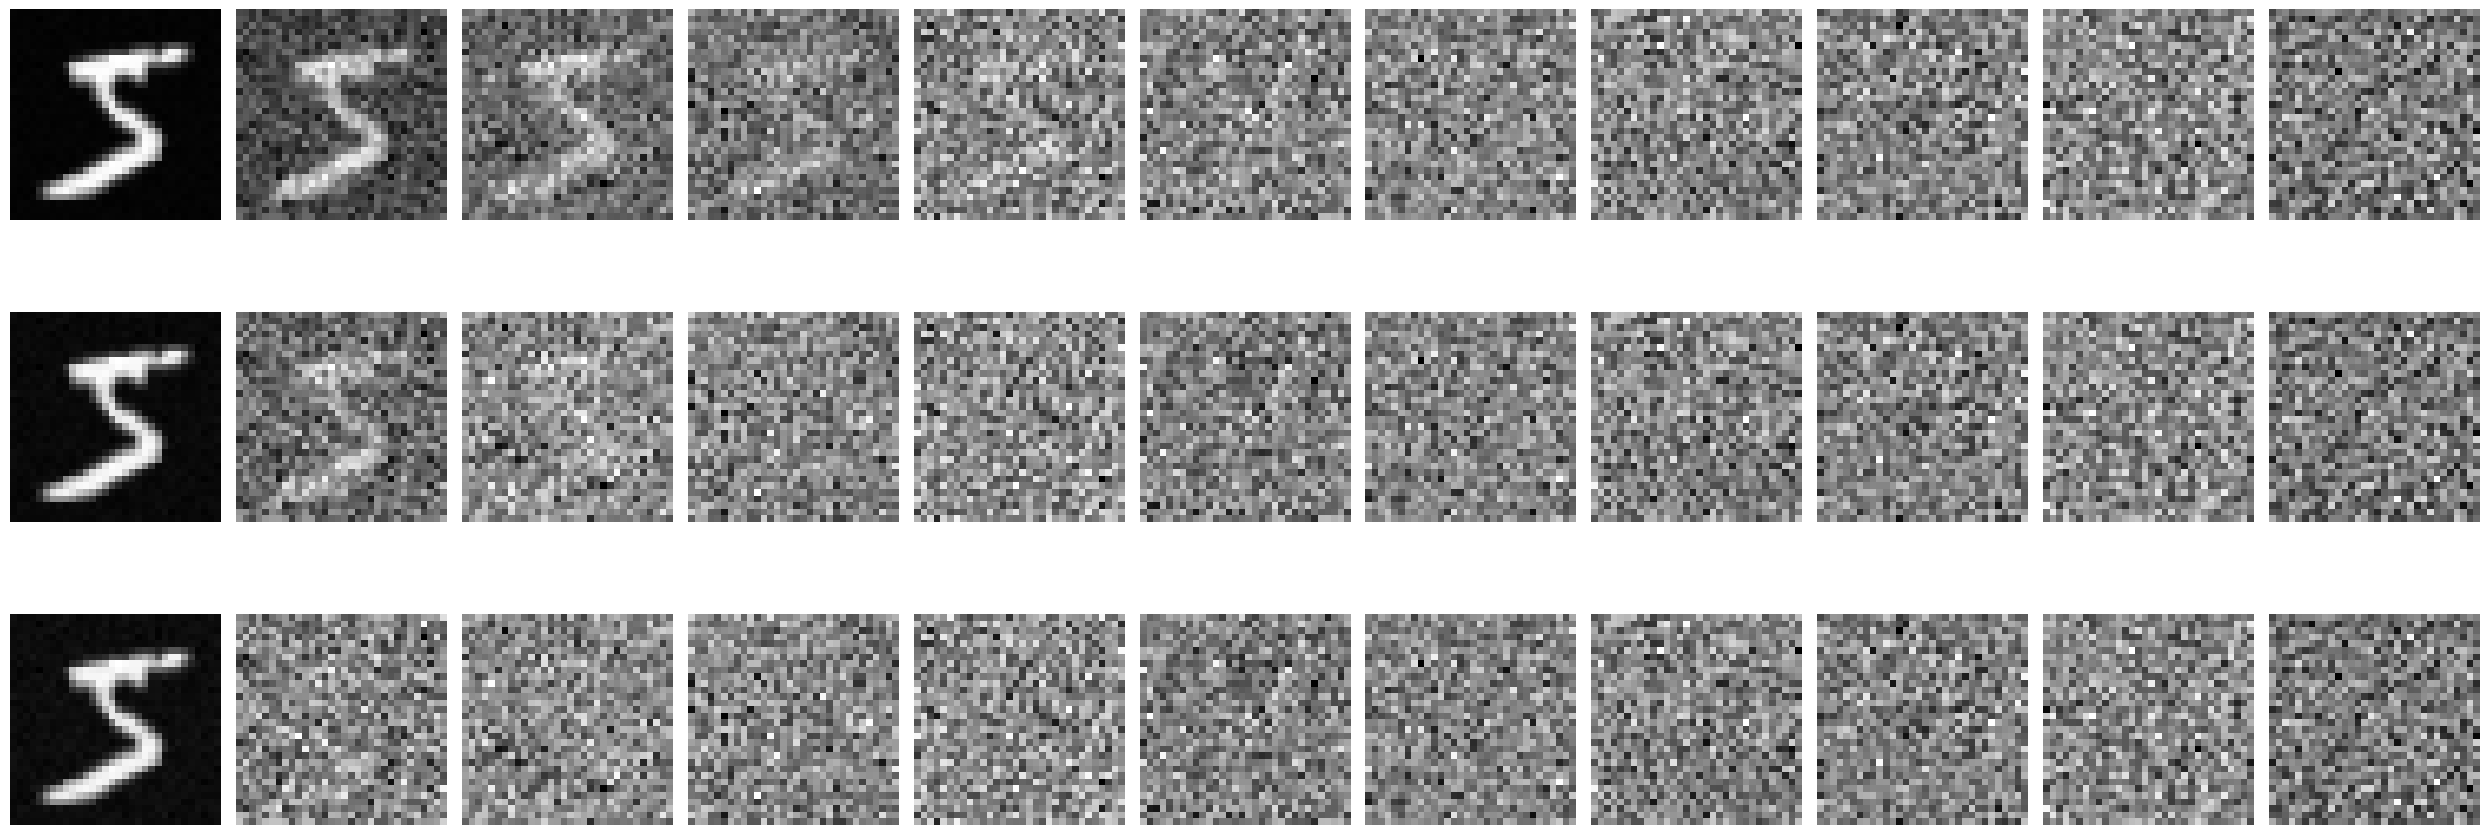

In [11]:
params_list = [
    {'time_steps': 1000, 'beta_start': 0.0001, 'beta_end': 0.02},
    {'time_steps': 500, 'beta_start': 0.0005, 'beta_end': 0.05},
    {'time_steps': 200, 'beta_start': 0.001, 'beta_end': 0.1},
]

# Prepare data
get_img = training_dataset[0][0]
get_img_stack = torch.stack([get_img]*11)
get_noise_stack = torch.randn_like(get_img_stack)
t_step = torch.linspace(start=0, end=1000-1, steps=11).long()

# Generate noisy images for different parameter settings
fig, axes = plt.subplots(nrows=len(params_list), ncols=11, figsize=(25, 10))

for i, params in enumerate(params_list):
    scheduler = Linear_Variance_Scheduler(time_steps=params['time_steps'],
                                          beta_start=params['beta_start'],
                                          beta_end=params['beta_end'],
                                          device='cpu')
    noisy_img_stack = scheduler.diffusion_process(get_img_stack, get_noise_stack, t_step)
    
    for idx, img in enumerate(noisy_img_stack):
        axes[i, idx].imshow(img.squeeze(), cmap='gray')
        if idx == 0:
            axes[i, idx].set_ylabel(f"Steps: {params['time_steps']}\nBeta: [{params['beta_start']}, {params['beta_end']}]")
        axes[i, idx].axis(False)

plt.tight_layout()
plt.show()

#### U-net Architecture:
- Resblock
- SelfAttentionBlock
- Downblock
- Upblock

# Create ResBlock

In [12]:
class ResBlock(nn.Module):
    def __init__(self, inp_ch, out_ch, mid_ch=None, residual=False):
        super(ResBlock, self).__init__()
        
        self.residual = residual
        if not mid_ch:
            mid_ch = out_ch
        self.resnet_conv = nn.Sequential()
        self.resnet_conv.add_module('conv1', nn.Conv2d(in_channels=inp_ch, out_channels=mid_ch, kernel_size=3, stride=1,
                                                       padding=1))
        self.resnet_conv.add_module('gnor1', nn.GroupNorm(num_groups=8, num_channels=mid_ch))
        self.resnet_conv.add_module('silu1', nn.SiLU())
        self.resnet_conv.add_module('conv2', nn.Conv2d(in_channels=mid_ch, out_channels=out_ch, kernel_size=3, stride=1,
                                                       padding=1))
        self.resnet_conv.add_module('gnor2', nn.GroupNorm(num_groups=8, num_channels=out_ch))
        
    def forward(self, x):
        if self.residual:
            return x + self.resnet_conv(x)
        else:
            return self.resnet_conv(x)

# Create SelfAttentionBlock

In [13]:
import torch
import torch.nn as nn

def _match_dimensions(tensor, target_h, target_w):
    _, _, h, w = tensor.size()
    delta_h = target_h - h
    delta_w = target_w - w
    pad_h = (delta_h // 2, delta_h - delta_h // 2)
    pad_w = (delta_w // 2, delta_w - delta_w // 2)
    return nn.functional.pad(tensor, pad_w + pad_h)


class SelfAttentionBlock(nn.Module):
    def __init__(self, channels, num_heads=4):
        super(SelfAttentionBlock, self).__init__()
        self.pre_norm = nn.LayerNorm(channels)
        self.attn = nn.MultiheadAttention(embed_dim=channels, num_heads=num_heads, batch_first=True)
        # self.post_norm = nn.LayerNorm(channels)

    def forward(self, x):
        b, c, h, w = x.shape
        x_reshaped = x.view(b, c, h * w).permute(0, 2, 1)  # Shape: (b, hw, c)
        x_norm = self.pre_norm(x_reshaped)
        attn_output, _ = self.attn(x_norm, x_norm, x_norm)
        # attn_output = self.post_norm(attn_output)
        attn_output = attn_output.permute(0, 2, 1).view(b, c, h, w)
        return x + attn_output


# Create DownBlock

In [14]:
class DownBlock(nn.Module):
    def __init__(self, inp_ch, out_ch, t_emb_dim=256):
        super(DownBlock, self).__init__()
        self.down = nn.Sequential(
            nn.MaxPool2d(kernel_size=2, stride=2),
            ResBlock(inp_ch=inp_ch, out_ch=inp_ch, residual=True),
            ResBlock(inp_ch=inp_ch, out_ch=out_ch)
        )
        self.t_emb_layers = nn.Sequential(
            nn.SiLU(),
            nn.Linear(t_emb_dim, out_ch)
        )

    def forward(self, x, t):
        x = self.down(x)
        t_emb = self.t_emb_layers(t).unsqueeze(-1).unsqueeze(-1)
        return x + t_emb


# Create UpBlock

In [15]:
class UpBlock(nn.Module):
    def __init__(self, inp_ch, out_ch, t_emb_dim=256):
        super(UpBlock, self).__init__()

        self.upsamp = nn.UpsamplingBilinear2d(scale_factor=2)

        self.up = nn.Sequential(
            # First ResBlock reduces channels, no residual connection
            ResBlock(inp_ch=inp_ch, out_ch=out_ch, residual=False),
            # Second ResBlock with residual connection, channels match
            ResBlock(inp_ch=out_ch, out_ch=out_ch, residual=True)
        )

        self.t_emb_layers = nn.Sequential(
            nn.SiLU(),
            nn.Linear(t_emb_dim, out_ch)
        )

    def forward(self, x, skip, t):
        x = self.upsamp(x)
        # Align dimensions before concatenation
        skip = self._match_dimensions(skip, x)
        x = torch.cat([skip, x], dim=1)
        x = self.up(x)
        t_emb = self.t_emb_layers(t)[:, :, None, None]
        return x + t_emb

    @staticmethod
    def _match_dimensions(skip, x):
        _, _, h_x, w_x = x.size()
        _, _, h_s, w_s = skip.size()
        delta_h = h_x - h_s
        delta_w = w_x - w_s

        pad_h = (delta_h // 2, delta_h - delta_h // 2)
        pad_w = (delta_w // 2, delta_w - delta_w // 2)

        return nn.functional.pad(skip, (pad_w[0], pad_w[1], pad_h[0], pad_h[1]))


# Create UNet

In [16]:
class UNet(nn.Module):
    def __init__(self, t_emb_dim, device='cuda'):
        super(UNet, self).__init__()
        
        self.device = device
        self.t_emb_dim = t_emb_dim
        
        self.inp = ResBlock(inp_ch=1, out_ch=64)
        self.down1 = DownBlock(inp_ch=64, out_ch=128)
        self.sa1 = SelfAttentionBlock(channels=128)
        self.down2 = DownBlock(inp_ch=128, out_ch=256)
        self.sa2 = SelfAttentionBlock(channels=256)
        self.down3 = DownBlock(inp_ch=256, out_ch=256)
        self.sa3 = SelfAttentionBlock(channels=256)
        
        self.lat1 = ResBlock(inp_ch=256, out_ch=512)
        self.lat2 = ResBlock(inp_ch=512, out_ch=512)
        self.lat3 = ResBlock(inp_ch=512, out_ch=256)
        
        self.up1 = UpBlock(inp_ch=512, out_ch=128)
        self.sa4 = SelfAttentionBlock(channels=128)
        self.up2 = UpBlock(inp_ch=256, out_ch=64)
        self.sa5 = SelfAttentionBlock(channels=64)
        self.up3 = UpBlock(inp_ch=128, out_ch=64)
        self.sa6 = SelfAttentionBlock(channels=64)
        
        self.out = nn.Conv2d(in_channels=64, out_channels=1, kernel_size=1)
        
    def position_embeddings(self, t, channels):
        i = 1 / (10000 ** (torch.arange(start=0, end=channels, step=2, device=self.device) / channels))
        pos_emb_sin = torch.sin(t.repeat(1, channels//2) * i)
        pos_emb_cos = torch.cos(t.repeat(1, channels//2) * i)
        pos_emb = torch.cat([pos_emb_sin, pos_emb_cos], dim=-1)
        return pos_emb
    
    def forward(self, x, t):
        t = t.unsqueeze(1).float()
        t = self.position_embeddings(t, self.t_emb_dim)
        
        x1 = self.inp(x)
        x2 = self.down1(x1, t)
        x2 = self.sa1(x2)
        x3 = self.down2(x2, t)
        x3 = self.sa2(x3)
        x4 = self.down3(x3, t)
        x4 = self.sa3(x4)
        
        x4 = self.lat1(x4)
        x4 = self.lat2(x4)
        x4 = self.lat3(x4)
        
        x = self.up1(x4, x3, t)
        x = self.sa4(x)
        x = self.up2(x, x2, t)
        x = self.sa5(x)
        x = self.up3(x, x1, t)
        x = self.sa6(x)
        output = self.out(x)
        return output

In [17]:
def initialize_weights(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)
    elif isinstance(m, nn.Linear):
        nn.init.xavier_normal_(m.weight)
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)
    elif isinstance(m, nn.BatchNorm2d):
        nn.init.constant_(m.weight, 1)
        nn.init.constant_(m.bias, 0)


In [18]:
import torch
import torch.nn as nn

class GenericUNet(nn.Module):
    def __init__(self, t_emb_dim, start_channels=64, depth=4, device='cuda'):
        super(GenericUNet, self).__init__()
        
        self.device = device
        self.t_emb_dim = t_emb_dim
        self.depth = depth
        
        # Initial input block
        self.inp = ResBlock(inp_ch=1, out_ch=start_channels)
        
        # Downsampling blocks
        self.down_blocks = nn.ModuleList()
        self.sa_blocks_down = nn.ModuleList()
        channels = start_channels
        for _ in range(depth):
            self.down_blocks.append(DownBlock(inp_ch=channels, out_ch=channels * 2))
            self.sa_blocks_down.append(SelfAttentionBlock(channels=channels * 2))
            channels *= 2

        
        # Latent blocks
        self.latent_blocks = nn.Sequential(
            ResBlock(inp_ch=channels, out_ch=channels),
            ResBlock(inp_ch=channels, out_ch=channels),
            ResBlock(inp_ch=channels, out_ch=channels)
        )

        # Upsampling blocks
        self.up_blocks = nn.ModuleList()
        self.sa_blocks_up = nn.ModuleList()
        for _ in range(depth):
            # Adjust `inp_ch` for concatenation of skip connection and upsampled tensor
            self.up_blocks.append(UpBlock(inp_ch=channels + channels, out_ch=channels // 2, t_emb_dim=t_emb_dim))
            self.sa_blocks_up.append(SelfAttentionBlock(channels=channels // 2))
            channels //= 2  # Halve the channels
        
        # Output block
        self.out = nn.Conv2d(in_channels=start_channels, out_channels=1, kernel_size=1)
        
        self.apply(initialize_weights)
    
    def position_embeddings(self, t, channels):
        i = 1 / (10000 ** (torch.arange(start=0, end=channels, step=2, device=self.device) / channels))
        pos_emb_sin = torch.sin(t.repeat(1, channels // 2) * i)
        pos_emb_cos = torch.cos(t.repeat(1, channels // 2) * i)
        pos_emb = torch.cat([pos_emb_sin, pos_emb_cos], dim=-1)
        return pos_emb
    
    def forward(self, x, t):
        t = t.unsqueeze(1).float()
        t = self.position_embeddings(t, self.t_emb_dim)
        
        # Downsampling path
        skip_connections = []
        # print(f"Input: {x.shape}")
        x = self.inp(x)
        # print(f"After input block: {x.shape}")
        skip_connections.append(x)
        for i, (down_block, sa_block) in enumerate(zip(self.down_blocks, self.sa_blocks_down)):
            x = down_block(x, t)
            # print(f"After down block {i + 1}: {x.shape}")
            # x = sa_block(x)
            # print(f"After self-attention {i + 1}: {x.shape}")
            skip_connections.append(x)
        
        # Latent path
        x = self.latent_blocks(x)
        # print(f"After latent blocks: {x.shape}")
        
        # Upsampling path
        for i, (up_block, sa_block) in enumerate(zip(self.up_blocks, self.sa_blocks_up)):
            skip_connection = skip_connections.pop()
            # print(f"Skip connection {i + 1}: {skip_connection.shape}")
            x = up_block(x, skip_connection, t)
            # print(f"After up block {i + 1}: {x.shape}")
            x = sa_block(x)
            # print(f"After self-attention {i + 1} (upsampling): {x.shape}")
        
        output = self.out(x)
        # print(f"Output: {output.shape}")
        return output
    
    def _match_dimensions(self, tensor, target_h, target_w):
        _, _, h, w = tensor.size()
        delta_h = target_h - h
        delta_w = target_w - w
        pad_h = (delta_h // 2, delta_h - delta_h // 2)
        pad_w = (delta_w // 2, delta_w - delta_w // 2)
        return nn.functional.pad(tensor, pad_w + pad_h)


In [19]:
from torchinfo import summary

# summary(UNet(t_emb_dim=256), input_size=[(64, 1, 32, 32), (64,)])


# SET-UP

In [20]:
from torch.optim.lr_scheduler import ExponentialLR


ddpm = Linear_Variance_Scheduler(time_steps=1000, beta_start=0.0001, beta_end=0.02)
model = GenericUNet(t_emb_dim=256, start_channels=32, depth=3, device=device).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
# scheduler = ExponentialLR(optimizer, gamma=0.95)
summary(model, input_size=[(64, 1, 28, 28), (64,)])

Layer (type:depth-idx)                             Output Shape              Param #
GenericUNet                                        [64, 1, 24, 24]           346,752
├─ResBlock: 1-1                                    [64, 32, 28, 28]          --
│    └─Sequential: 2-1                             [64, 32, 28, 28]          --
│    │    └─Conv2d: 3-1                            [64, 32, 28, 28]          320
│    │    └─GroupNorm: 3-2                         [64, 32, 28, 28]          64
│    │    └─SiLU: 3-3                              [64, 32, 28, 28]          --
│    │    └─Conv2d: 3-4                            [64, 32, 28, 28]          9,248
│    │    └─GroupNorm: 3-5                         [64, 32, 28, 28]          64
├─ModuleList: 1-2                                  --                        --
│    └─DownBlock: 2-2                              [64, 64, 14, 14]          --
│    │    └─Sequential: 3-6                        [64, 64, 14, 14]          74,304
│    │    └─Sequential

# TRAINING

In [ ]:
torch.manual_seed(1111)
torch.cuda.manual_seed(1111)
torch.cuda.manual_seed_all(1111)
np.random.seed(1111)

n_epochs = 15
training_loss = torch.tensor([], device=device)
test_loss = torch.tensor([], device=device)




for epoch in range(n_epochs):
    training_losses = torch.tensor([], device=device)
    test_losses = torch.tensor([], device=device)
    
    for data, _ in tqdm(training_dataloader):
        model.train()
        data = data.to(device)
        t = torch.randint(low=0, high=1000, size=(data.shape[0],), device=device)
        noise = torch.randn_like(data, device=device)
        xt = ddpm.diffusion_process(x=data, noise=noise, t=t)
        pred_noise = model(xt, t)
        trng_batch_loss = criterion(noise, pred_noise)
        optimizer.zero_grad()
        trng_batch_loss.backward()
        optimizer.step()
        training_losses = torch.cat((training_losses, trng_batch_loss.unsqueeze(0)))
    training_per_epoch_loss = training_losses.mean()
    
    with torch.inference_mode():
        for data, _ in tqdm(test_dataloader):
            model.eval()
            data = data.to(device)
            t = torch.randint(low=0, high=1000, size=(data.shape[0],), device=device)
            noise = torch.randn_like(data, device=device)
            xt = ddpm.diffusion_process(x=data, noise=noise, t=t)
            pred_noise = model(xt, t)
            tst_batch_loss = criterion(noise, pred_noise)
            test_losses = torch.cat((test_losses, tst_batch_loss.unsqueeze(0)))
        test_per_epoch_loss = test_losses.mean()
    
    # scheduler.step()
    training_loss = torch.cat((training_loss, training_per_epoch_loss.unsqueeze(0)))
    test_loss = torch.cat((test_loss, test_per_epoch_loss.unsqueeze(0)))
    
    print(f'Epoch: {epoch+1}/{n_epochs}\t| Training loss: {training_per_epoch_loss:.4f} |   ', end='')
    print(f'Test loss: {test_per_epoch_loss:.4f}')

100%|██████████| 50/50 [00:02<00:00, 16.69it/s]


Epoch: 1/15	| Training loss: 4.2056 |   Test loss: 1.2393


100%|██████████| 50/50 [00:03<00:00, 15.82it/s]


Epoch: 2/15	| Training loss: 1.1612 |   Test loss: 1.0951


 78%|███████▊  | 235/300 [01:07<00:18,  3.50it/s]

# Plot losses

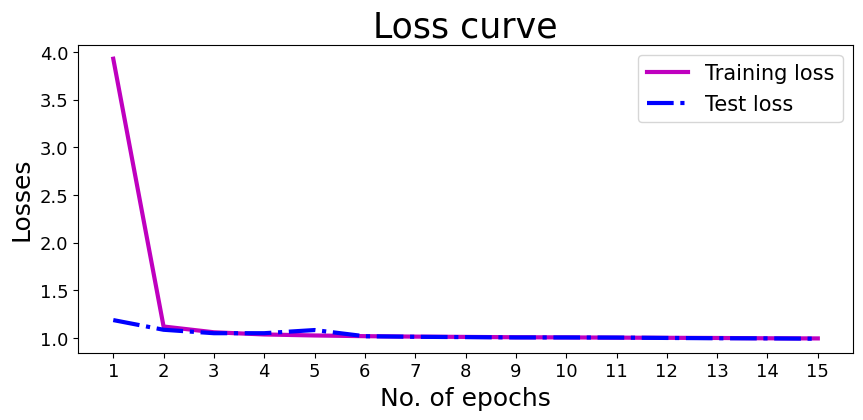

In [ ]:
N = np.arange(n_epochs) + 1

plt.figure(figsize=(10, 4))
plt.plot(N, training_loss.detach().cpu(), 'm-', linewidth=3, label='Training loss')
plt.plot(N, test_loss.detach().cpu(), 'b-.', linewidth=3, label='Test loss')
plt.title('Loss curve', fontsize=25)
plt.xlabel('No. of epochs', fontsize=18)
plt.ylabel('Losses', fontsize=18)
plt.xticks(N, fontsize=13)
plt.yticks(fontsize=13)
plt.legend(fontsize=15)

# Reverse process

In [ ]:
_, collect = ddpm.ddpm_sampling(model=model, num_samples=1, channels=1, img_size=32)


1000it [00:08, 122.36it/s]


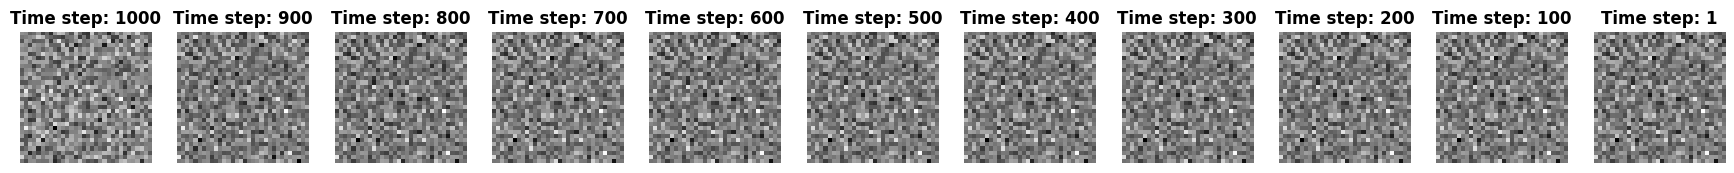

In [ ]:
step = [1000, 900, 800, 700, 600, 500, 400, 300, 200, 100, 1]
fig, axis = plt.subplots(nrows=1, ncols=11, figsize=(22, 2))

j = 0
for ax, _ in zip(axis.ravel(), range(11)):
    ax.imshow(collect[j][0].detach().cpu().permute(1, 2, 0), cmap='gray')
    ax.set_title(f'Time step: {step[j]}', fontweight='bold')
    ax.axis(False)
    j += 1

# Random sampling from noise

In [ ]:
sampled_imgs, _ = ddpm.ddpm_sampling(model=model, num_samples=64, channels=1, img_size=32)



1000it [00:20, 49.43it/s]


(-0.5, 545.5, 137.5, -0.5)

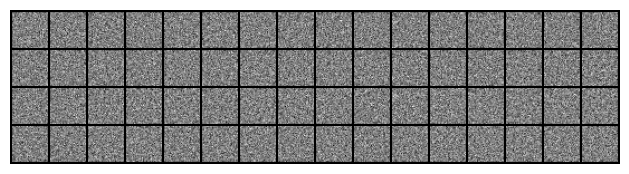

In [ ]:
grid = make_grid(sampled_imgs.detach().cpu(), nrow=16, normalize=True)
plt.figure(figsize=(12, 2))
plt.imshow(grid.permute(1, 2, 0), cmap='gray')
plt.axis(False)

**TODO**
## EVALUATION